# Getting ground truth

## Leader pos

### Incomplete samples

In [1]:
import argparse, sys
from typing import Dict
import pysam
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
incomplete = ["MH687962", "MH687952", "MH687946", "KY770850", "MH687957", "MH687950", "MH687964", "KP143511",
              "MN611522", "NC_028824", "MK472071", "NC_028833", "KX512809", "KX512810", "NC_034440", "KP662631",
              "MH878976", "KX272465", "KP780179", "KY933089", "MG021194", "AY646283", "KM454473", "KX432213",
              "KY073748", "KJ473810", "NC_028814", "NC_022103", "KY799179", "JX993987", "KJ473815", "KJ473816",
              "JX993988", "NC_014470", "MT121216"]

In [4]:
df_super_raw = pd.read_excel("../result/SuPER/Supplementary_Tables.xlsx", sheet_name=3, engine='openpyxl')
df_super_raw.rename(columns={"Unnamed: 4": "Leader seq", "Unnamed: 6": "Body seq", "Unnamed: 7": "Body"}, inplace=True)

In [5]:
df_super_raw[(~df_super_raw["Accession"].isna()) & (df_super_raw["Subgenus"].isna())]

,Accession,Genus,Subgenus,TRS-L,Leader seq,TRS-B,Body seq,Body
2131,KY770850,Alphacoronavirus,NaN,NaN,NaN,NaN,NaN,NaN
2132,KY770851,Alphacoronavirus,NaN,67,AACTAAAC,20381,AACTAAAT,spike glycoprotein:20392-24579
2801,MK472070,Alphacoronavirus,NaN,21,AATCTAAT,20448,GATGTAAT,spike protein:20497-24666
3446,NC_035191,Alphacoronavirus,NaN,31,AACTAAAC,23279,TACTAAAC,envelope protein:23306-23533
3484,NC_046955,Alphacoronavirus,NaN,73,AACTAAAA,24568,AACTTAAA,envelope protein:24614-24850
3491,NC_046965,Gammacoronavirus,NaN,64,CTTAACA,23606,CCTAAGA,ORF3:23616-23777


In [6]:
def get_ref(file):
    fasta = pysam.Fastafile(file)
    return fasta.fetch(fasta.references[0])

In [7]:
d_core = {
    "Andecovirus":       "GACACCA",
    "Buldecovirus":      "GACACCA",
    "Cegacovirus":       "ATTAAAC",
    "Colacovirus":       "CTTAACA",
    "Decacovirus":       "AACTAAAC",
    "Duvinacovirus":     "AACTAAAC",
    "Embecovirus":       "ATCTAAAC",
    "Herdecovirus":      "GACACCGA",
    "Hibecovirus":       "AACGAAC",
    "Igacovirus":        "CTTAACA", # Several are different
    "Luchacovirus":      "AACTAAAC",
    "Merbecovirus":      "AACGAAC",
    "Minacovirus":       "AACTAAAC",
    "Minunacovirus":     "AACTAAAC",
    "Moordecovirus":     "GACACCA",
    "Myotacovirus":      "AACTAAAC",
    "Nobecovirus":       "AACGAAC",
    "Nyctacovirus":      "AACTAAAC",
    "Pedacovirus":       "AACTAAAC",
    "Rhinacovirus":      "AACTAAAC",
    "Sarbecovirus":      "AACGAAC",
    "Setracovirus":      "AACTAAAC",
    "Tegacovirus":       "AACTAAAC",
}

In [8]:
# some samples are different than others in their subgenera
exceptional = {
    "EU637854": "CCTAACA",
    "GQ504723": "CTTTACA",
    "KY407556": "TTTAACA",
    "MK581206": "CTTAASA",
    "MK211372": "AACCTAAC",
    "KY770860": "TACGAAC",
    "MN996532": "AACGAACTTT",
}
# 8 unclassfied
unclassified = {
    "KY770850": "AACTAAAC",
    "KY770851": "AACTAAAC",
    "MK472070": "AATCTAAT",
    "NC_035191": "AACTAAAC",
    "NC_046955": "AACTAAAA",
    "NC_046965": "CTTAACA",
}

In [9]:
gt_leader = {}
gt_leader_seq = {}
for _, row in df_super_raw[(~df_super_raw["Accession"].isna())].iterrows():
    sample = row["Accession"]
    if sample == "EPI_ISL_412977":
        continue
    elif sample in exceptional:
        ref = get_ref(f"../data/fasta/{sample}.fasta")
        gt_leader[sample] = ref.find(exceptional[sample])
        gt_leader_seq[sample] = exceptional[sample]
    elif sample in unclassified:
        ref = get_ref(f"../data/fasta/{sample}.fasta")
        gt_leader[sample] = ref.find(unclassified[sample])
        gt_leader_seq[sample] = unclassified[sample]
    else:
        ref = get_ref(f"../data/fasta/{sample}.fasta")
        gt_leader[sample] = ref.find(d_core[row["Subgenus"]])
        gt_leader_seq[sample] = d_core[row["Subgenus"]]
for sample in gt_leader:
    if gt_leader[sample] > 1000:
        gt_leader[sample] = np.nan
        gt_leader_seq[sample] = None

## Leader

range: between the end of SL2 and start of SL4

In [10]:
from Bio import AlignIO

In [11]:
data = [
    ["Andecovirus",    "NC_016995",    55,    126],
    ["Buldecovirus",   "KX834351",     63,    103],
    ["Cegacovirus",    "KF793824",     60,    78],
    ["Colacovirus",    None, None, None],
    ["Decacovirus",    "MG916901",     64,    82],
    ["Duvinacovirus",  "MN611517",     47,    68],
    ["Embecovirus",    "NC_017083",     50,    82],
    ["Herdecovirus",   "NC_016994",    57,    120],
    ["Hibecovirus",    "NC_025217",    62,    85],
    ["Igacovirus",     "AY514485",     52,    69],
    ["Luchacovirus",   "NC_032730",    62,    79],
    ["Merbecovirus",   "NC_019843",    52,    78],
    ["Minacovirus",    "HM245926",     61,    79],
    ["Minunacovirus",  "KJ473798",     58,    74],
    ["Moordecovirus",  "NC_016996",    55,    123],
    ["Myotacovirus",   "NC_028811",    59,    76],
    ["Nobecovirus",    "EF065514",     59,    82],
    ["Nyctacovirus",   "MK720944",     45,    61],
    ["Pedacovirus",    "KR061458",     27,    45],
    ["Rhinacovirus",   "NC_009988",    61,    77],
    ["Sarbecovirus",   "NC_045512",    61,    76],
    ["Setracovirus",   "KY073746",     14,    30],
    ["Tegacovirus",    "KX722529",     54,    85],
]
df_range = pd.DataFrame(data, columns=["subgenus", "sample", "start", "end"]).set_index("subgenus")
df_range["start"] -= 1

In [12]:
unclassified_range = {
    "KY770851": (59, 80), # Duvina?
    "MK472067": (73, 91),
    "MN065811": (58, 76),
    "NC_035191": (26, 46),
    "NC_046955": (64, 85),
    "NC_046965": (60, 77),
    "MK472070": (13, 29),
}

In [13]:
def ref_to_align_idx(align, idx):
    j = -1
    for i, c in enumerate(align):
        if c != "-":
            j += 1
        if j == idx:
            return i
        
def align_to_ref_idx(align, idx):
    n_gap = align[:idx].count('-')
    return idx - n_gap

In [14]:
gt_range = {row["sample"]: (row["start"], row["end"]) for i, row in df_range.iterrows()}
gt_range.update({sample: (s, e) for sample, (s, e) in unclassified_range.items()})
for file in glob.glob("../data/leader_align/*.aln"):
    subgenus = file.split('/')[-1].split('_')[0]
    align = AlignIO.read(file, "clustal")
    row = df_range.loc[subgenus, :]
    sample = row["sample"]
    if sample is None:
        continue
    start = row["start"]
    end = row["end"]
    seqs = {rec.id: str(rec.seq) for rec in align}
    align_start = ref_to_align_idx(seqs[sample], start)
    align_end = ref_to_align_idx(seqs[sample], end)
    for sample, seq in seqs.items():
        s = align_to_ref_idx(seqs[sample], align_start)
        e = align_to_ref_idx(seqs[sample], align_end)
        gt_range[sample] = (s, e)
        ref = get_ref(f"../data/fasta/{sample}.fasta")

In [15]:
df_leader_range = pd.DataFrame({"sample": gt_leader.keys(),
                          "genus": [df_super_raw.loc[df_super_raw["Accession"] == n, "Genus"].values[0] for n in gt_leader],
                          "subgenus": [df_super_raw.loc[df_super_raw["Accession"] == n, "Subgenus"].values[0] for n in gt_leader],
                          "start": [gt_range[s][0] if s in gt_range else None for s in gt_leader.keys()],
                          "end": [gt_range[s][1] if s in gt_range else None for s in gt_leader.keys()],
                         }).set_index("sample")

In [16]:
df_leader = pd.DataFrame({"sample": gt_leader.keys(),
                          "genus": [df_super_raw.loc[df_super_raw["Accession"] == n, "Genus"].values[0] for n in gt_leader],
                          "subgenus": [df_super_raw.loc[df_super_raw["Accession"] == n, "Subgenus"].values[0] for n in gt_leader],
                          "pos": [v+1 for v in gt_leader.values()],
                          "seq": [v for v in gt_leader_seq.values()],
                         }).set_index("sample")

Text(0.5, 0, 'TRS-L ground truth region length')

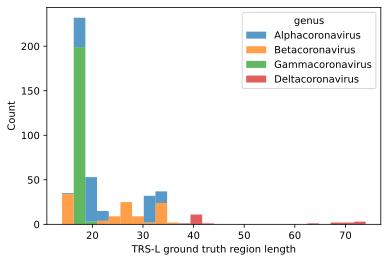

In [17]:
df_leader_range["length"] = df_leader_range["end"] - df_leader_range["start"]
sns.histplot(data=df_leader_range[~df_leader_range.index.isin(incomplete)], x="length", hue="genus", multiple="stack", linewidth=0.,
             hue_order=["Alphacoronavirus", "Betacoronavirus", "Gammacoronavirus", "Deltacoronavirus"])
plt.xlabel("TRS-L ground truth region length")

In [18]:
df_leader_range[~df_leader_range.index.isin(incomplete)].sort_values("length")

,genus,subgenus,start,end,length
sample,,,,,
KJ473814,Betacoronavirus,Sarbecovirus,0.0,14.0,14.0
KU973692,Betacoronavirus,Sarbecovirus,57.0,73.0,16.0
KY417142,Betacoronavirus,Sarbecovirus,57.0,73.0,16.0
KY417143,Betacoronavirus,Sarbecovirus,57.0,73.0,16.0
FJ588686,Betacoronavirus,Sarbecovirus,38.0,54.0,16.0
...,...,...,...,...,...
NC_011547,Deltacoronavirus,Buldecovirus,59.0,129.0,70.0
FJ376620,Deltacoronavirus,Buldecovirus,59.0,129.0,70.0
NC_016995,Deltacoronavirus,Andecovirus,54.0,126.0,72.0


In [19]:
df_leader_range.to_csv("ground_truth/gt_leader_range.csv")
df_leader.to_csv("ground_truth/gt_leader.csv")

## Hist of leader length

In [20]:
def get_df_orf(ref, frame=0):
    possible_orf = []
    start_pos = []
    start_pos.append(ref.find('ATG'))
    while start_pos[-1] != -1:
        start_pos.append(ref.find('ATG', start_pos[-1]+1))

    stop_codons = ["TAA", "TAG", "TGA"]
    stop_pos = []
    for i in range(len(ref)-3):
        if ref[i:i+3] in stop_codons:
            stop_pos.append(i)

    possible_orf = []
    for start in start_pos:
        for stop in stop_pos:
            if stop > start and (stop - start) % 3 == frame:
                possible_orf.append((start, stop))
                break

    df_orf = pd.DataFrame(possible_orf, columns=["start", "stop"])
    df_orf["length"] = df_orf["stop"] - df_orf["start"]
    df_orf.sort_values("start", inplace=True)
    return df_orf.iloc[1:, :]

def predict_ORFs(seq: str):
    """Predict putative ORFs"""
    length = len(seq)
    start_pos = []
    start_pos.append(seq.find('ATG'))
    while True:
        next_start = seq.find('ATG', start_pos[-1]+1)
        if next_start != -1:
            start_pos.append(next_start)
        else:
            break
    next_start = [None] * length
    pointer = 0
    for i in range(length):
        if i <= start_pos[pointer]+2:
            next_start[i] = start_pos[pointer]
        else:
            pointer += 1
            if pointer < len(start_pos):
                next_start[i] = start_pos[pointer]
            else:
                break

    stop_codons = ["TAA", "TAG", "TGA"]
    stop_pos = []
    for i in range(length-3):
        if seq[i:i+3] in stop_codons:
            stop_pos.append(i)

    possible_trs = {}
    for start in start_pos:
        for stop in stop_pos:
            if stop > start and (stop - start) % 3 == 0:
                possible_trs[start] = stop
                break
        else:
            possible_trs[start] = length - 1

    return next_start, possible_trs

def guess_orf1ab_start(ref):
    df_orf = get_df_orf(ref)

    percent = 0.21
    orf1a_end = None
    df_orf1a = df_orf[df_orf["stop"] > len(ref) * percent]
    if len(df_orf1a) > 0:
        return df_orf1a.iloc[0]["start"]
    else:
        return None
    
def guess_orf1ab_end(ref):
    df_orf = get_df_orf(ref)
    df_orf.to_csv("debug.tsv", sep='\t', index=False)

    percent = 0.21
    orf1a_end = None
    df_orf1a = df_orf[df_orf["stop"] > len(ref) * percent]
    if len(df_orf1a) > 0:
        orf1a_end = df_orf1a.iloc[0]["stop"]

    df_orf1ab = df_orf[(df_orf["start"] > orf1a_end - 100) & (
        (df_orf["stop"] - df_orf["start"]) > len(ref) * percent)]
    if len(df_orf1ab) > 0:
        return df_orf1ab.iloc[0]["stop"]

In [21]:
files = glob.glob("../data/fasta/*.fasta")
df_orf1ab_start = []
df_orf1ab_end = []
for file in files:
    sample = file.split("/")[-1].split(".")[0]
    tmp = pysam.Fastafile(file)
    df_orf1ab_start.append([sample, guess_orf1ab_start(tmp.fetch(tmp.references[0])), df_leader.loc[sample, "genus"], df_leader.loc[sample, "subgenus"]])
    df_orf1ab_end.append([sample, guess_orf1ab_end(tmp.fetch(tmp.references[0])), df_leader.loc[sample, "genus"], df_leader.loc[sample, "subgenus"]])
df_orf1ab_start = pd.DataFrame(df_orf1ab_start, columns=["sample", "length", "genus", "subgenus"])
df_orf1ab_end = pd.DataFrame(df_orf1ab_end, columns=["sample", "length", "genus", "subgenus"]).set_index("sample")

In [22]:
df_orf1ab_start["max_length"] =  df_orf1ab_start.groupby(['subgenus'])['length'].transform(np.median)
df_orf1ab_start["diff_length"] = df_orf1ab_start["max_length"] - df_orf1ab_start["length"]
df_orf1ab_start["incomplete"] = df_orf1ab_start["sample"].isin(incomplete)
df_orf1ab_start["3rd quart"] = df_orf1ab_start.groupby(['subgenus'])['diff_length'].transform(lambda x: x.quantile(0.75))
df_orf1ab_start

,sample,length,genus,subgenus,max_length,diff_length,incomplete,3rd quart
0,AC_000192,214,Betacoronavirus,Embecovirus,209.0,-5.0,False,13.00
1,AF220295,210,Betacoronavirus,Embecovirus,209.0,-1.0,False,13.00
2,AY319651,529,Gammacoronavirus,Igacovirus,525.0,-4.0,False,0.00
3,AY514485,526,Gammacoronavirus,Igacovirus,525.0,-1.0,False,0.00
4,AY646283,330,Gammacoronavirus,Igacovirus,525.0,195.0,True,0.00
...,...,...,...,...,...,...,...,...
500,NC_046954,210,Betacoronavirus,Embecovirus,209.0,-1.0,False,13.00
501,NC_046955,339,Alphacoronavirus,NaN,NaN,NaN,False,NaN
502,NC_046964,280,Alphacoronavirus,Nyctacovirus,278.5,-1.5,False,36.25
503,NC_046965,553,Gammacoronavirus,NaN,NaN,NaN,False,NaN


Text(0.5, 0, 'Leader Length')

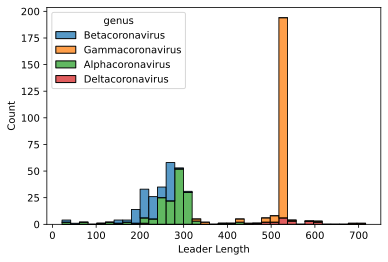

In [23]:
ax = sns.histplot(x="length", hue="genus", data=df_orf1ab_start.loc[df_orf1ab_start["length"] <= 1000, :],
                  multiple="stack", bins=35)
ax.set_xlabel("Leader Length")

## Regions: body core seqs

In [24]:
from convert import convert

def parse_attributes(attr: str):
    return dict(pair.split('=') for pair in attr.split(";") if len(pair) > 0)

def get_candidate_region(fasta_file: str, annotation_file: str):
    annot = pd.read_csv(annotation_file,
                        sep='\t',
                        header=None,
                        names=["id", "source", "feature", "start", "end",
                               "score", "strand", "phase", "attributes"],
                        comment='#')
    regions = {}
    names = set()
    for idx, row in annot[annot["feature"] == "CDS"].iterrows():
        infos = parse_attributes(row["attributes"])
        if "gene" in infos:
            name = infos["gene"]
        elif "product" in infos:
            name = infos["product"]
        elif "pseudo" in infos and infos["pseudo"] == "true":
            continue
        else:
            print("No label: ", row)
            exit(1)

        known_name_of_1ab = {"1a", "1b", "1ab", "replicase", "pol"}
        if any(n in name.lower() for n in known_name_of_1ab) or name.lower() == "1" or name.lower() == "orf1":
            continue

        if name in regions:
            # take the union region
            regions[name] = (min(regions[name][0], row["start"] - 1),
                             max(regions[name][1], row["end"] - 1))
        else:
            regions[name] = (row["start"] - 1, row["end"] - 1)
    return regions

def get_annotation_region(fasta_file: str, annotation_file: str):
    annot = pd.read_csv(annotation_file,
                        sep='\t',
                        header=None,
                        names=["id", "source", "feature", "start", "end",
                               "score", "strand", "phase", "attributes"],
                        comment='#')
    regions = {}
    names = set()
    for idx, row in annot[annot["feature"] == "CDS"].iterrows():
        infos = parse_attributes(row["attributes"])
        if "gene" in infos:
            name = infos["gene"].lower()
        elif "product" in infos:
            name = infos["product"].lower()
        elif "pseudo" in infos and infos["pseudo"] == "true":
            continue
        else:
            print("No label: ", row)
            exit(1)

        known_name_of_1ab = {"1a", "1b", "1ab",
                             "replicase", "polymerase", "polyprotein", "pol", "rep",}
        if any(n in name.lower() for n in known_name_of_1ab) or name.lower() == '1' or name.lower() == 'orf1':
            continue

        if name in convert:
            name = convert[name]
        if name.startswith("hypothetical protein"):
            name = name[20:].strip() + '?'
        if name.startswith("non-structural protein"):
            name = "ns" + name[22:].strip()
        if name.startswith("nonstructural protein"):
            name = "ns" + name[21:].strip()
        if name.startswith("putative"):
            name = name[8:].strip() + '??'
        if name.endswith("protein"):
            name = name[:-7].strip()
        if name.startswith("protein"):
            name = name[7:].strip()
        if name.startswith("orf"):
            name = name[3:].strip()
        if name in regions:
            a = regions[name][0]
            b = regions[name][1]
            c = row["start"] - 1
            d = row["end"] - 1
            if (
                (a <= d and c <= b and
                (min(b, d) - max(a, c)) / (max(b, d) - min(a, c)) >= 0.1)
            ):
                regions[name] = (min(a, c), max(b, d))
            else:
                while name in regions:
                    name += '#'
                regions[name] = (row["start"] - 1, row["end"] - 1)
        else:
            regions[name] = (row["start"] - 1, row["end"] - 1)
    return regions

In [25]:
files = glob.glob("../data/gff/*.gff")
d_regions = {}
for file in files:
    sample = file.split('/')[-1].split('.')[0]
    d_regions[sample] = get_annotation_region(f"../data/fasta/{sample}.fasta", f"../data/gff/{sample}.gff")    

In [26]:
with open("ground_truth/gt_regions.json", "w") as ofile:
    json.dump(d_regions, ofile)

In [27]:
df_regions = pd.DataFrame([[sample,
                            df_leader.loc[sample, "genus"],
                            df_leader.loc[sample, "subgenus"],
                            len(r),
                            sample in incomplete] for sample, r in d_regions.items()],
                          columns=["sample", "genus", "subgenus", "n_genes", "incomplete"])
df_regions.sort_values("n_genes")

,sample,genus,subgenus,n_genes,incomplete
25,EU526388,Gammacoronavirus,Igacovirus,0,False
8,DQ288927,Gammacoronavirus,Igacovirus,0,False
447,NC_001846,Betacoronavirus,Embecovirus,3,False
326,MG893511,Alphacoronavirus,Tegacovirus,4,False
390,MK211379,Betacoronavirus,Nobecovirus,4,False
...,...,...,...,...,...
463,NC_010646,Gammacoronavirus,Cegacovirus,12,False
452,NC_004718,Betacoronavirus,Sarbecovirus,12,False
114,KF793824,Gammacoronavirus,Cegacovirus,13,False
442,MN690608,Gammacoronavirus,Cegacovirus,13,False


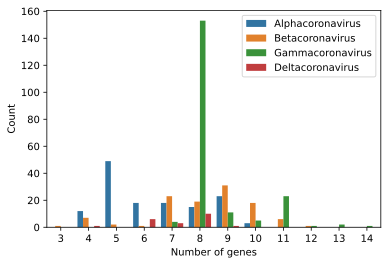

In [28]:
sns.countplot(data=df_regions[(~df_regions["incomplete"]) & (df_regions["n_genes"] > 0)], x="n_genes",
              hue="genus", hue_order=["Alphacoronavirus", "Betacoronavirus", "Gammacoronavirus", "Deltacoronavirus"])
plt.xlabel("Number of genes")
plt.ylabel("Count")
plt.legend(loc="upper right")

In [29]:
files = glob.glob("../data/gff/*.gff")
df_gff = []
known_name_of_1ab = {"1a", "1b", "1ab", "replicase", "pol", "rep"}
for file in files:
    sample = file.split('/')[-1].split('.')[0]
    annot = pd.read_csv(file,
                        sep='\t',
                        header=None,
                        names=["id", "source", "feature", "start", "end",
                               "score", "strand", "phase", "attributes"],
                        comment='#')
    for idx, row in annot[annot["feature"] == "CDS"].iterrows():
        infos = parse_attributes(row["attributes"])
        if "gene" in infos:
            name = infos["gene"]
        elif "product" in infos:
            name = infos["product"]
        elif "pseudo" in infos and infos["pseudo"] == "true":
            continue
        else:
            print("No label: ", row)
            break
        if any(n in name.lower() for n in known_name_of_1ab) or name.lower() == "1" or name.lower() == "orf1":
            continue
        df_gff.append([sample, df_leader.loc[sample, "genus"], df_leader.loc[sample, "subgenus"], sample in incomplete, name, row["start"]-1, row["end"]-1])
df_gff = pd.DataFrame(df_gff, columns=["sample", "genus", "subgenus", "incomplete", "ORF", "start", "end"])
df_gff["length"] = df_gff["end"] - df_gff["start"]

In [30]:
df_gff[df_gff["length"] < 100]

,sample,genus,subgenus,incomplete,ORF,start,end,length
46,DQ011855,Betacoronavirus,Embecovirus,False,NS4.9,27465,27539,74
1360,KU558922,Betacoronavirus,Embecovirus,False,4.9kDa,27721,27798,77
1361,KU558922,Betacoronavirus,Embecovirus,False,4.8kDa,27931,28020,89
1370,KU886219,Betacoronavirus,Embecovirus,False,nonstructural protein,27695,27784,89
1984,KX432213,Betacoronavirus,Embecovirus,True,2.7 kDa non-structural protein,27824,27901,77
2359,KY994645,Betacoronavirus,Embecovirus,False,NS4.9,27681,27743,62
2631,MG916901,Alphacoronavirus,Decacovirus,False,orf3b,24977,25069,92
3024,MK217372,Gammacoronavirus,Igacovirus,False,3a,23885,23983,98
3494,NC_003045,Betacoronavirus,Embecovirus,False,4.9 kDa non-structural protein,27721,27810,89
3754,NC_028806,Alphacoronavirus,Tegacovirus,False,non-structural protein 3a,24492,24584,92


Text(0.5, 0, 'Gene length')

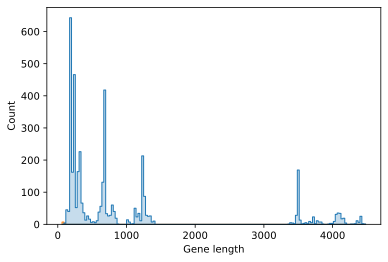

In [31]:
ax = sns.histplot(df_gff[df_gff["length"] <= 8000], x="length", log_scale=(False, False), hue=df_gff["length"] <= 100, bins=160, element="step")
ax.legend_.remove()
ax.set_xlabel("Gene length")

## ORF1ab

In [32]:
def get_orf1ab(fasta_file: str, annotation_file: str):
    annot = pd.read_csv(annotation_file,
                        sep='\t',
                        header=None,
                        names=["id", "source", "feature", "start", "end",
                               "score", "strand", "phase", "attributes"],
                        comment='#')
    l_1ab = []
    for idx, row in annot[annot["feature"] == "CDS"].iterrows():
        infos = parse_attributes(row["attributes"])
        if "gene" in infos:
            name = infos["gene"]
        elif "product" in infos:
            name = infos["product"]
        elif "pseudo" in infos and infos["pseudo"] == "true":
            continue
        else:
            print("No label: ", row)

        known_name_of_1ab = {"1a", "1b", "1ab", "replicase", "polymerase", "polyprotein", "pol"}
        if any(n in name.lower() for n in known_name_of_1ab) or name.lower() == '1' or name.lower() == 'orf1':
            l_1ab.append((name, row["start"] - 1, row["end"] - 1))
    return l_1ab

files = glob.glob("../data/gff/*.gff")
d_orf1ab = {}
for file in files:
    sample = file.split('/')[-1].split('.')[0]
    l_1ab = get_orf1ab(f"../data/fasta/{sample}.fasta", f"../data/gff/{sample}.gff")
    if len(l_1ab) > 0:
        d_orf1ab[sample] = [min(a[1] for a in l_1ab), max(a[2] for a in l_1ab)]
    else:
        d_orf1ab[sample] = None

In [33]:
d_orf1ab["DQ648857"] = [263, 21501]
d_orf1ab["KX443143"] = [539, 19327]

In [34]:
with open("ground_truth/gt_orf1ab.json", "w") as ofile:
    json.dump(d_orf1ab, ofile)